# Maps of time-mean cold point temperature for the obs climo


In [10]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


In [2]:
file_path = "/work/bb1153/b380887/big_obs_climo/"
# save_dir = "/home/b/b380887/cold-point-overshoot/plots/obs_paper/cpT_mean_spatial/"
save_dir = "/home/b/b380887/cold-point-overshoot/plots/obs_paper/paper_figs/"


In [4]:
years_str = "2007-2010"
season_list = ["DJF", "JJA"]


In [5]:
# coordinates for the region boxes for the map

ecp_coords = [-150, -100, 0, 15]
wpc_coords = [130, 180, 0, 15]
afr_coords = [-7, 35, 0, 18]
ioe_coords = [53, 95, -12, 6]
amz_coords = [-72, -47, -30, 0]
spc_coords = [165, -145, -20, -5]
ios_coords = [50, 100, -15, 0]


In [6]:
region_dict = {}
coords_dict = {}
width_dict = {}
height_dict = {}


In [7]:
region_dict["DJF"] = ["AMZ", "SPC1", "SPC2", "ECP", "IOS"]
coords_dict["DJF"] = {
    "AMZ": amz_coords, 
    "SPC": spc_coords, 
    "IOS": ios_coords, 
    "ECP": ecp_coords
}
width_dict["DJF"] = dict(zip(coords_dict["DJF"].keys(), [25, 50, 50, 50]))
height_dict["DJF"] = dict(zip(coords_dict["DJF"].keys(), [30, 15, 15, 15]))

region_dict["JJA"] = ["AFR", "WPC", "IOE", "ECP"]
coords_dict["JJA"] = {
    "AFR": afr_coords, 
    "WPC": wpc_coords, 
    "IOE": ioe_coords, 
    "ECP": ecp_coords
}
width_dict["JJA"] = dict(zip(region_dict["JJA"], [42, 50, 42, 50]))
height_dict["JJA"] = dict(zip(region_dict["JJA"], [18, 15, 18, 15]))


Coordinates for where to put the region labels:

In [31]:
# 6 degrees above/below, centered otherwise (except for land)
xy_dict = {}
xy_dict["DJF"] = {
    "AMZ": (-59.5, 6), 
    # "AMZ": (-86, -20), # adjusted
    "SPC": (-170, 1),
    "IOS": (75, -22),
    "ECP": (-125, 21)
}
xy_dict["JJA"] = {
    "AFR": (14, 24),
    # "AFR": (-20, 9), # adjusted
    "WPC": (155, 21),
    "IOE": (74, -20),
    "ECP": (-125, 21)
}

### Read in the mean temperatures/heights

In [9]:
cpT_season_dict = {}
cpz_season_dict = {}

for i, season in enumerate(season_list):
    cpT_dict = {}
    cpz_dict = {}

    for region in region_dict[season]:
        # split the SPC region for plotting
        if region == "SPC1":
            ds_all = xr.open_dataset(file_path + "Tb_os_thresholds/ERA5_0.25deg_cp_thresh_{s}{y}_SPC.nc".format(s=season, y=years_str))
            cpT_dict["SPC1"] = ds_all["cpT"].sel(longitude=slice(None, 180))
            cpT_dict["SPC2"] = ds_all["cpT"].sel(longitude=slice(-180, None))
            cpz_dict["SPC1"] = ds_all["cpz"].sel(longitude=slice(None, 180))
            cpz_dict["SPC2"] = ds_all["cpz"].sel(longitude=slice(-180, None))
        elif region == "SPC2":
            continue
        else:
            ds = xr.open_dataset(file_path + "Tb_os_thresholds/ERA5_0.25deg_cp_thresh_{s}{y}_{r}.nc".format(s=season, y=years_str, r=region))
            cpT_dict[region] = ds["cpT"]
            cpz_dict[region] = ds["cpz"]
            
    cpT_season_dict[season] = cpT_dict
    cpz_season_dict[season] = cpz_dict


## Plot

### Seasons together, with temperature & height

In [59]:
def plot_cpT_cpz_all(cpT_season_dict, cpz_season_dict, coords_dict, season_list, years_str, cmap_t="viridis", cmap_z="viridis_r", save_dir=save_dir,
                    fsize=26, tsize=30, labsize=24, figsize=(34, 8),
                    central_lon=80, vlims_t=None, levels_z=np.arange(16, 18, 0.1), 
                     levels_t=np.arange(185, 201, 1), xy_dict=None, save=False):
    """Plot the heatmap after it's been calculated
    """
    plot_lons = [*np.arange(-100, 181, 40), *np.arange(-140, -99, 40)]
    plot_lats = np.arange(-30, 31, 15)
            
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(3, 13, height_ratios=[0.1, 1, 1], hspace=0.3, wspace=0.5)
    
    ax_title_left = fig.add_subplot(gs[0, :6])
    ax_title_right = fig.add_subplot(gs[0, 6:-1])
    
    ax_t1 = plt.subplot(gs[1, :6], projection=ccrs.PlateCarree(central_longitude=central_lon))
    ax_t2 = plt.subplot(gs[1, 6:12], projection=ccrs.PlateCarree(central_longitude=central_lon))
    ax_t_list = [ax_t1, ax_t2]

    ax_z1 = plt.subplot(gs[2, :6], projection=ccrs.PlateCarree(central_longitude=central_lon))
    ax_z2 = plt.subplot(gs[2, 6:12], projection=ccrs.PlateCarree(central_longitude=central_lon))
    ax_z_list = [ax_z1, ax_z2]

    ax_cb_t = plt.subplot(gs[1, 12:])
    ax_cb_z = plt.subplot(gs[2, 12:])

    
    for i, season in enumerate(season_list):
        cpT_dict = cpT_season_dict[season]
        cpz_dict = cpz_season_dict[season]
        ax_t = ax_t_list[i]
        ax_z = ax_z_list[i]
        coords_dict_season = coords_dict[season]
        width_dict_season = width_dict[season]
        height_dict_season = height_dict[season]

        for region in list(cpT_dict.keys()):
            cpT = cpT_dict[region]
            cpz = cpz_dict[region]

            # -central_longitude is an artifical offset to get the plotting longitudes aligned correctly with cartopy & pcolormesh
            cf1 = ax_t.contourf(cpT.longitude-central_lon, cpT.latitude, cpT, cmap=cmap_t, levels=levels_t)
            cf2 = ax_z.contourf(cpz.longitude-central_lon, cpz.latitude, cpz/1000., cmap=cmap_z, levels=levels_z)

            # add region borders
            if region == "SPC2":
                coords = coords_dict_season["SPC"]
                width = width_dict_season["SPC"]
                height = height_dict_season["SPC"]
            elif region == "SPC1":
                coords = None
                width = None
                height = None
            else:
                coords = coords_dict_season[region]
                width = width_dict_season[region]
                height = height_dict_season[region]
            if region != "SPC1":
                ax_t.add_patch(mpatches.Rectangle(xy=[coords[0], coords[2]], 
                                                width=width, 
                                                height=height,
                                                fill=False, color='k', linewidth=2,
                                                transform=ccrs.PlateCarree()
                                               ))
                ax_z.add_patch(mpatches.Rectangle(xy=[coords[0], coords[2]], 
                                                width=width, 
                                                height=height,
                                                fill=False, color='k', linewidth=2,
                                                transform=ccrs.PlateCarree()
                                               ))
                
        ax_t.set_title("Time-mean cold point temperature", fontsize=tsize, loc="center")
        ax_z.set_title("Time-mean cold point height", fontsize=tsize, loc="center")
        
    # gridlines & labels
    for ax in [ax_t1, ax_z1]:
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                            xlocs=plot_lons, ylocs=plot_lats, x_inline=False, y_inline=False, color = "None")
        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {'size': labsize, 'rotation': 0}#20}
        gl.ylabel_style = {'size': labsize}
        ax.add_feature(cfeature.COASTLINE)
        ax.set_ylim((plot_lats[0], plot_lats[-1]))
    for ax in [ax_t2, ax_z2]:
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                            xlocs=plot_lons, ylocs=plot_lats, x_inline=False, y_inline=False, color = "None")
        gl.top_labels = False
        gl.left_labels = False
        gl.right_labels = False
        gl.xlabel_style = {'size': labsize, 'rotation': 0}#20}
        gl.ylabel_style = {'size': labsize}
        ax.add_feature(cfeature.COASTLINE)
        ax.set_ylim((plot_lats[0], plot_lats[-1]))
        
    # colorbars
    ax_cb_t.axis("off")
    axins_1 = inset_axes(ax_cb_t, width="20%", height="100%", loc="center left")
    cbar_t = plt.colorbar(cf1, cax=axins_1, orientation="vertical")
    cbar_t.set_label("Temperature (K)", fontsize=fsize)
    cbar_t.ax.tick_params(labelsize=labsize)
    ax_cb_z.axis("off")
    axins_2 = inset_axes(ax_cb_z, width="20%", height="100%", loc="center left")
    cbar_z = plt.colorbar(cf2, cax=axins_2, orientation="vertical")
    cbar_z.set_label("Height (km)", fontsize=fsize)
    cbar_z.ax.tick_params(labelsize=labsize)
    


    # title
    ax_title_left.axis("off")
    ax_title_left.text(x=0.5, y=0, s="{s} {y}".format(s=season_list[0], y=years_str.replace("-", "—")), verticalalignment="center",
                  horizontalalignment="center", fontsize=tsize+5
                  )
    ax_title_right.axis("off")
    ax_title_right.text(x=0.5, y=0, s="{s} {y}".format(s=season_list[1], y=years_str.replace("-", "—")), verticalalignment="center",
                  horizontalalignment="center", fontsize=tsize+5
                  )

    # annotate region labels
    for i, season in enumerate(season_list):
        ax_t = ax_t_list[i]
        ax_z = ax_z_list[i]
        transform_t = ccrs.PlateCarree()._as_mpl_transform(ax_t)
        transform_z = ccrs.PlateCarree()._as_mpl_transform(ax_z)
        for region in xy_dict[season].keys():
            ax_t.annotate(region, xy_dict[season][region], xycoords=transform_t,
                          ha="center", va="center", fontsize=tsize, weight="bold")
            ax_z.annotate(region, xy_dict[season][region], xycoords=transform_z,
                          ha="center", va="center", fontsize=tsize, weight="bold")

    if save:
        plt.savefig(save_dir + "mean_cpT_cpz_maps_SI.png", bbox_inches="tight", dpi=300)

    plt.show()


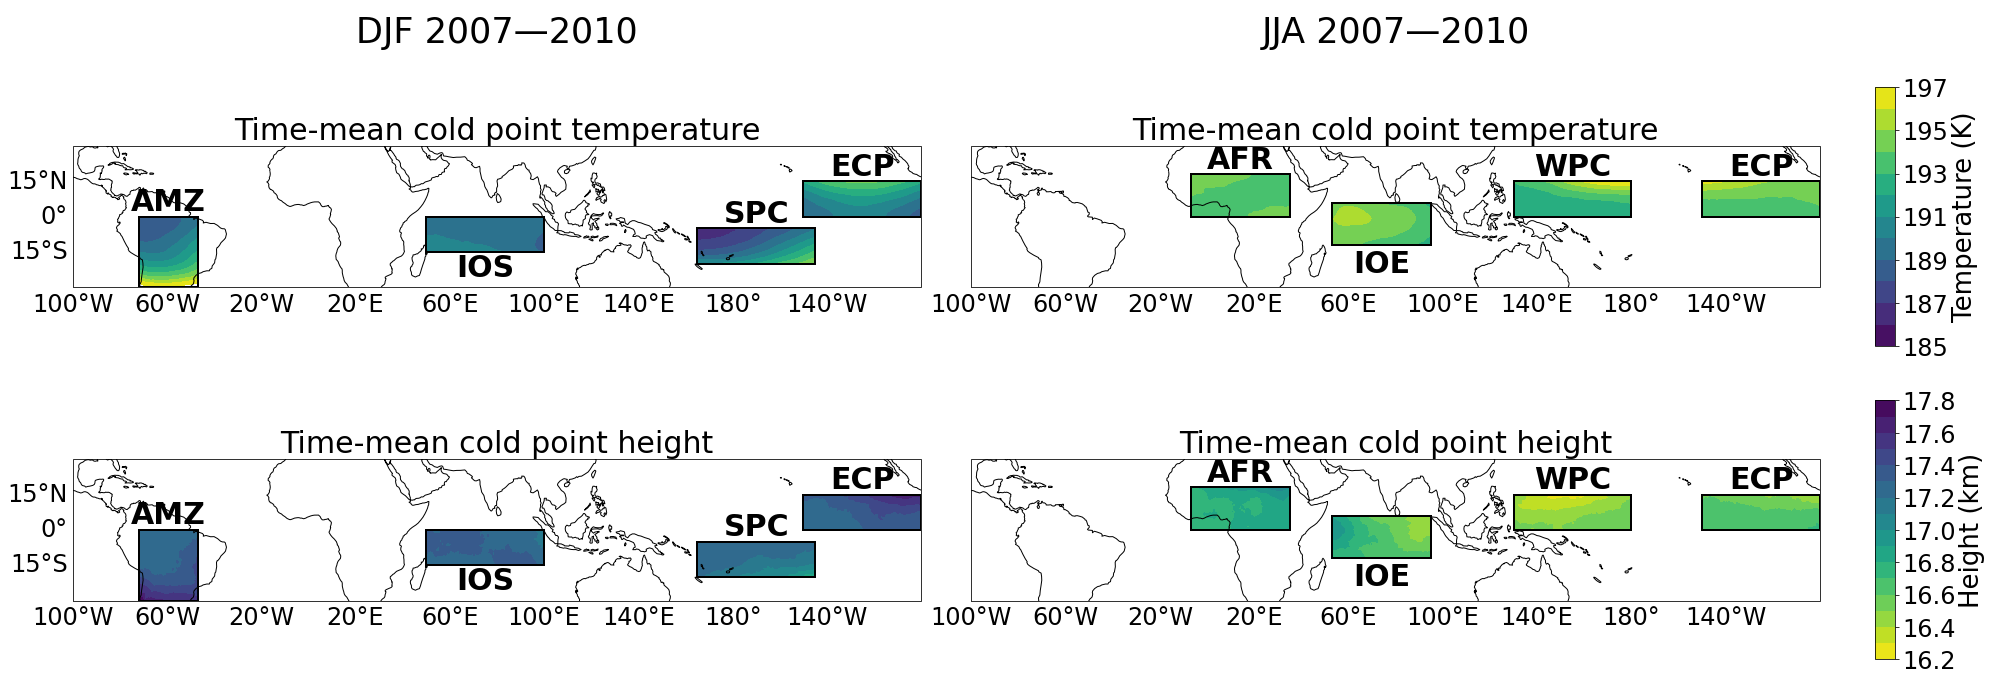

In [60]:
# SI

plot_cpT_cpz_all(cpT_season_dict, cpz_season_dict, coords_dict, ["DJF", "JJA"], 
                 years_str, cmap_t="viridis", cmap_z="viridis_r",
                 levels_t=np.arange(185, 198, 1), levels_z=np.arange(16.2, 17.9, 0.1),
                 save=True, figsize=(34, 12), xy_dict=xy_dict)
